# Applying Classification Modeling
The goal of this week's assessment is to find the model which best predicts whether or not a person will default on their bank loan. In doing so, we want to utilize all of the different tools we have learned over the course: data cleaning, EDA, feature engineering/transformation, feature selection, hyperparameter tuning, and model evaluation. 


#### Data Set Information:

This research aimed at the case of customers default payments in Taiwan and compares the predictive accuracy of probability of default among six data mining methods. From the perspective of risk management, the result of predictive accuracy of the estimated probability of default will be more valuable than the binary result of classification - credible or not credible clients. Because the real probability of default is unknown, this study presented the novel Sorting Smoothing Method to estimate the real probability of default. With the real probability of default as the response variable (Y), and the predictive probability of default as the independent variable (X), the simple linear regression result (Y = A + BX) shows that the forecasting model produced by artificial neural network has the highest coefficient of determination; its regression intercept (A) is close to zero, and regression coefficient (B) to one. Therefore, among the six data mining techniques, artificial neural network is the only one that can accurately estimate the real probability of default. 

- NT is the abbreviation for New Taiwan. 


#### Attribute Information:

This research employed a binary variable, default payment (Yes = 1, No = 0), as the response variable. This study reviewed the literature and used the following 23 variables as explanatory variables: 
- X1: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit. 
- X2: Gender (1 = male; 2 = female). 
- X3: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others). 
- X4: Marital status (1 = married; 2 = single; 3 = others). 
- X5: Age (year). 
- X6 - X11: History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows: 
    - X6 = the repayment status in September, 2005; 
    - X7 = the repayment status in August, 2005; . . .;
    - etc...
    - X11 = the repayment status in April, 2005. 
    - The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above. 
- X12-X17: Amount of bill statement (NT dollar). 
    - X12 = amount of bill statement in September, 2005;
    - etc...
    - X13 = amount of bill statement in August, 2005; . . .; 
    - X17 = amount of bill statement in April, 2005. 
- X18-X23: Amount of previous payment (NT dollar). 
    - X18 = amount paid in September, 2005; 
    - X19 = amount paid in August, 2005; . . .;
    - etc...
    - X23 = amount paid in April, 2005. 




You will fit three different models (KNN, Logistic Regression, and Decision Tree Classifier) to predict credit card defaults and use gridsearch to find the best hyperparameters for those models. Then you will compare the performance of those three models on a test set to find the best one.  


## Process/Expectations

- You will be working in pairs for this assessment

### Please have ONE notebook and be prepared to explain how you worked in your pair.

1. Clean up your data set so that you can perform an EDA. 
    - This includes handling null values, categorical variables, removing unimportant columns, and removing outliers.
2. Perform EDA to identify opportunities to create new features.
    - [Great Example of EDA for classification](https://www.kaggle.com/stephaniestallworth/titanic-eda-classification-end-to-end) 
    - [Using Pairplots with Classification](https://towardsdatascience.com/visualizing-data-with-pair-plots-in-python-f228cf529166)
3. Engineer new features. 
    - Create polynomial and/or interaction features. 
    - Additionaly, you must also create **at least 2 new features** that are not interactions or polynomial transformations. 
        - *For example, you can create a new dummy variable that based on the value of a continuous variable (billamount6 >2000) or take the average of some past amounts.*
4. Perform some feature selection. 
    
5. You must fit **three** models to your data and tune **at least 1 hyperparameter** per model. 
6. Using the F-1 Score, evaluate how well your models perform and identify your best model.
7. Using information from your EDA process and your model(s) output provide insight as to which borrowers are more likely to deafult


In [647]:
# import libraries
import sys
sys.path.insert(0, '../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, confusion_matrix,\
recall_score, precision_score, accuracy_score, log_loss,\
roc_curve, roc_auc_score, classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.model_selection import train_test_split, KFold, GridSearchCV,\
cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix

## 1. Data Cleaning

In [573]:
df = pd.read_csv('training_data.csv' , index_col=0)

In [574]:
df.Y.value_counts()

0                             17471
1                              5028
default payment next month        1
Name: Y, dtype: int64

In [575]:
df.head()

X1 X2 X3 X4  X5  X6  X7  X8  X9 X10  ...     X15     X16     X17  \
28835  220000  2  1  2  36   0   0   0   0   0  ...  221193  181859  184605   
25329  200000  2  3  2  29  -1  -1  -1  -1  -1  ...     326     326     326   
18894  180000  2  1  2  27  -2  -2  -2  -2  -2  ...       0       0       0   
690     80000  1  2  2  32   0   0   0   0   0  ...   43882   42256   42527   
6239    10000  1  2  2  27   0   0   0   0   0  ...    5444    2639    2697   

         X18   X19    X20   X21    X22     X23  Y  
28835  10000  8018  10121  6006  10987  143779  1  
25329    326   326    326   326    326     326  0  
18894      0     0      0     0      0       0  0  
690     1853  1700   1522  1548   1488    1500  0  
6239    2000  1100    600   300    300    1000  1  

[5 rows x 24 columns]

In [576]:
# Rename columns for readability
df.rename(columns = {'X1':'credit_limit', 'X2':'gender', 'X3':'education', 'X4':'marital_status', 'X5':'age', 'X6':'repay_sep',\
                    'X7':'repay_aug', 'X8':'repay_jul', 'X9':'repay_jun', 'X10':'repay_may', 'X11':'repay_apr', 'X12':'bill_sep', 'X13':'bill_aug',\
                    'X14':'bill_jul', 'X15':'bill_jun', 'X16':'bill_may', 'X17':'bill_apr', 'X18':'pay_sep', 'X19':'pay_aug', 'X20':'pay_jul',\
                    'X21':'pay_jun', 'X22':'pay_may', 'X23':'pay_apr','Y':'default'}, inplace = True)

In [577]:
df.head()

credit_limit gender education marital_status age repay_sep repay_aug  \
28835       220000      2         1              2  36         0         0   
25329       200000      2         3              2  29        -1        -1   
18894       180000      2         1              2  27        -2        -2   
690          80000      1         2              2  32         0         0   
6239         10000      1         2              2  27         0         0   

      repay_jul repay_jun repay_may  ... bill_jun bill_may bill_apr pay_sep  \
28835         0         0         0  ...   221193   181859   184605   10000   
25329        -1        -1        -1  ...      326      326      326     326   
18894        -2        -2        -2  ...        0        0        0       0   
690           0         0         0  ...    43882    42256    42527    1853   
6239          0         0         0  ...     5444     2639     2697    2000   

      pay_aug pay_jul pay_jun pay_may pay_apr default  
28835    8018   10121    6006   10987  143779       1  
25329     326     326     326     326     326       0  
18894       0       0       0       0       0       0  
690      1700    1522    1548    1488    1500       0  
6239     1100     600     300     300    1000       1  

[5 rows x 24 columns]

In [578]:
# weird values in this row. best to delete
df.iloc[18381]

credit_limit                       LIMIT_BAL
gender                                   SEX
education                          EDUCATION
marital_status                      MARRIAGE
age                                      AGE
repay_sep                              PAY_0
repay_aug                              PAY_2
repay_jul                              PAY_3
repay_jun                              PAY_4
repay_may                              PAY_5
repay_apr                              PAY_6
bill_sep                           BILL_AMT1
bill_aug                           BILL_AMT2
bill_jul                           BILL_AMT3
bill_jun                           BILL_AMT4
bill_may                           BILL_AMT5
bill_apr                           BILL_AMT6
pay_sep                             PAY_AMT1
pay_aug                             PAY_AMT2
pay_jul                             PAY_AMT3
pay_jun                             PAY_AMT4
pay_may                             PAY_AMT5
pay_apr   

In [579]:
taiwan = df.drop(df.index[18381])
taiwan.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22499 entries, 28835 to 7624
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   credit_limit    22499 non-null  object
 1   gender          22499 non-null  object
 2   education       22499 non-null  object
 3   marital_status  22499 non-null  object
 4   age             22499 non-null  object
 5   repay_sep       22499 non-null  object
 6   repay_aug       22499 non-null  object
 7   repay_jul       22499 non-null  object
 8   repay_jun       22499 non-null  object
 9   repay_may       22499 non-null  object
 10  repay_apr       22499 non-null  object
 11  bill_sep        22499 non-null  object
 12  bill_aug        22499 non-null  object
 13  bill_jul        22499 non-null  object
 14  bill_jun        22499 non-null  object
 15  bill_may        22499 non-null  object
 16  bill_apr        22499 non-null  object
 17  pay_sep         22499 non-null  object
 18  pay_aug 

### New Dataframe with Adjusted Column Data Types

In [580]:
# convert non-categorical data types to integer for analysis
# taiwan[['credit_limit', 'gender', 'education', 'marital_status', 'age', 'bill_sep', 'bill_aug', 'bill_jul', 'bill_jun', 'bill_may', 'bill_apr',\
#         'pay_sep', 'pay_aug', 'pay_jul', 'pay_jun', 'pay_may', 'pay_apr', 'default']] = taiwan[['credit_limit', 'gender', 'education', 'marital_status', 'age',\
#         'bill_sep', 'bill_aug', 'bill_jul', 'bill_jun', 'bill_may', 'bill_apr', 'pay_sep', 'pay_aug', 'pay_jul',\
#         'pay_jun', 'pay_may', 'pay_apr', 'default']].apply(pd.to_numeric)

taiwan = taiwan.apply(pd.to_numeric)
taiwan.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22499 entries, 28835 to 7624
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   credit_limit    22499 non-null  int64
 1   gender          22499 non-null  int64
 2   education       22499 non-null  int64
 3   marital_status  22499 non-null  int64
 4   age             22499 non-null  int64
 5   repay_sep       22499 non-null  int64
 6   repay_aug       22499 non-null  int64
 7   repay_jul       22499 non-null  int64
 8   repay_jun       22499 non-null  int64
 9   repay_may       22499 non-null  int64
 10  repay_apr       22499 non-null  int64
 11  bill_sep        22499 non-null  int64
 12  bill_aug        22499 non-null  int64
 13  bill_jul        22499 non-null  int64
 14  bill_jun        22499 non-null  int64
 15  bill_may        22499 non-null  int64
 16  bill_apr        22499 non-null  int64
 17  pay_sep         22499 non-null  int64
 18  pay_aug         22499 non-nu

In [581]:
taiwan.head()

credit_limit  gender  education  marital_status  age  repay_sep  \
28835        220000       2          1               2   36          0   
25329        200000       2          3               2   29         -1   
18894        180000       2          1               2   27         -2   
690           80000       1          2               2   32          0   
6239          10000       1          2               2   27          0   

       repay_aug  repay_jul  repay_jun  repay_may  ...  bill_jun  bill_may  \
28835          0          0          0          0  ...    221193    181859   
25329         -1         -1         -1         -1  ...       326       326   
18894         -2         -2         -2         -2  ...         0         0   
690            0          0          0          0  ...     43882     42256   
6239           0          0          0          0  ...      5444      2639   

       bill_apr  pay_sep  pay_aug  pay_jul  pay_jun  pay_may  pay_apr  default  
28835    184605    10000     8018    10121     6006    10987   143779        1  
25329       326      326      326      326      326      326      326        0  
18894         0        0        0        0        0        0        0        0  
690       42527     1853     1700     1522     1548     1488     1500        0  
6239       2697     2000     1100      600      300      300     1000        1  

[5 rows x 24 columns]

In [582]:
taiwan.describe()

credit_limit        gender     education  marital_status  \
count    22499.000000  22499.000000  22499.000000    22499.000000   
mean    167054.521534      1.603227      1.855282        1.553358   
std     129864.960118      0.489239      0.791905        0.521418   
min      10000.000000      1.000000      0.000000        0.000000   
25%      50000.000000      1.000000      1.000000        1.000000   
50%     140000.000000      2.000000      2.000000        2.000000   
75%     240000.000000      2.000000      2.000000        2.000000   
max    1000000.000000      2.000000      6.000000        3.000000   

                age     repay_sep     repay_aug     repay_jul     repay_jun  \
count  22499.000000  22499.000000  22499.000000  22499.000000  22499.000000   
mean      35.447931     -0.014090     -0.128806     -0.160185     -0.214587   
std        9.237634      1.123191      1.197954      1.198880      1.174824   
min       21.000000     -2.000000     -2.000000     -2.000000     -2.000000   
25%       28.000000     -1.000000     -1.000000     -1.000000     -1.000000   
50%       34.000000      0.000000      0.000000      0.000000      0.000000   
75%       41.000000      0.000000      0.000000      0.000000      0.000000   
max       75.000000      8.000000      8.000000      8.000000      8.000000   

          repay_may  ...       bill_jun       bill_may       bill_apr  \
count  22499.000000  ...   22499.000000   22499.000000   22499.000000   
mean      -0.259700  ...   43329.149562   40306.373039   38955.000356   
std        1.139984  ...   64607.088483   60918.993067   59773.144959   
min       -2.000000  ...  -81334.000000  -81334.000000 -339603.000000   
25%       -1.000000  ...    2319.500000    1732.500000    1230.000000   
50%        0.000000  ...   19048.000000   18050.000000   16924.000000   
75%        0.000000  ...   54494.500000   50196.000000   49250.000000   
max        8.000000  ...  891586.000000  927171.000000  961664.000000   

             pay_sep       pay_aug        pay_jul        pay_jun  \
count   22499.000000  2.249900e+04   22499.000000   22499.000000   
mean     5627.914796  5.964393e+03    5258.912307    4792.971777   
std     16628.162287  2.444370e+04   18153.554633   15872.858180   
min         0.000000  0.000000e+00       0.000000       0.000000   
25%      1000.000000  8.290000e+02     396.000000     284.000000   
50%      2100.000000  2.004000e+03    1800.000000    1500.000000   
75%      5002.000000  5.000000e+03    4500.000000    4000.000000   
max    873552.000000  1.684259e+06  896040.000000  621000.000000   

             pay_may        pay_apr       default  
count   22499.000000   22499.000000  22499.000000  
mean     4865.656029    5247.279301      0.223477  
std     15507.449610   17892.327398      0.416584  
min         0.000000       0.000000      0.000000  
25%       246.500000     100.000000      0.000000  
50%      1500.000000    1500.000000      0.000000  
75%      4068.500000    4000.000000      0.000000  
max    388071.000000  528666.000000      1.000000  

[8 rows x 24 columns]

In [583]:
taiwan.shape

(22499, 24)

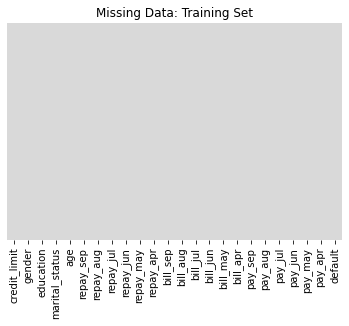

In [584]:
# Heatmap to double check missing data
sns.heatmap(taiwan.isnull(),yticklabels = False, cbar = False,cmap = 'tab20c_r')
plt.title('Missing Data: Training Set')
plt.show()

- Nothing missing

### Imputing and Binning Outlier Categories

- Education contains values of 5 and 6 that are unlabelled, moreover the category 0 is undocumented.
    - The 0 (undocumented), 5 and 6 (label unknown) in EDUCATION can also be put in a 'Other' cathegory (thus 4)
    <br><br>
- Marital Status has a label 0 that is undocumented.
    - The 0 in MARRIAGE can be safely categorized as 'Other' (thus 3).
    
- Repayment status has labels of -2 and 0 which are undocumented. 
    - Add to -1 for now to indicate paid on time, as they would not be delinquent.
    
- Extreme outliers in credit limit. 
    - Bring down to above the 75th percentile of 240,000NT to next highest value rounded up to 350,000.

In [585]:
print(taiwan['education'].value_counts())
print(taiwan['marital_status'].value_counts())

2    10516
1     7919
3     3713
5      208
4       90
6       42
0       11
Name: education, dtype: int64
2    12026
1    10195
3      234
0       44
Name: marital_status, dtype: int64


In [586]:
taiwan.credit_limit.value_counts(ascending = True)

327680        1
690000        1
740000        1
1000000       1
800000        1
           ... 
200000     1134
80000      1210
30000      1223
20000      1488
50000      2534
Name: credit_limit, Length: 80, dtype: int64

In [587]:
taiwan['education'] = np.where((taiwan.education == 5) | (taiwan.education == 6) | (taiwan.education == 0), 4, taiwan.education)
taiwan['education'].value_counts()

2    10516
1     7919
3     3713
4      351
Name: education, dtype: int64

In [588]:
taiwan['marital_status'] = np.where((taiwan.marital_status == 0), 3, taiwan.marital_status)
taiwan['marital_status'].value_counts()

2    12026
1    10195
3      278
Name: marital_status, dtype: int64

In [589]:
taiwan['repay_sep'] = np.where((taiwan.repay_sep == -2) | (taiwan.repay_sep == 0), -1, taiwan.repay_sep)
taiwan['repay_aug'] = np.where((taiwan.repay_aug == -2) | (taiwan.repay_aug == 0), -1, taiwan.repay_aug)
taiwan['repay_jul'] = np.where((taiwan.repay_jul == -2) | (taiwan.repay_jul == 0), -1, taiwan.repay_jul)
taiwan['repay_jun'] = np.where((taiwan.repay_jun == -2) | (taiwan.repay_jun == 0), -1, taiwan.repay_jun)
taiwan['repay_may'] = np.where((taiwan.repay_may == -2) | (taiwan.repay_may == 0), -1, taiwan.repay_may)
taiwan['repay_apr'] = np.where((taiwan.repay_apr == -2) | (taiwan.repay_apr == 0), -1, taiwan.repay_apr)

In [590]:
taiwan['credit_limit'] = np.where((taiwan.credit_limit > 240_000), 350_000, taiwan.credit_limit)

### Looking at Bills & Payments

In [591]:
bills = ['bill_sep', 'bill_aug', 'bill_jul', 'bill_jun', 'bill_may', 'bill_apr']

In [592]:
payment = ['pay_sep', 'pay_aug', 'pay_jul', 'pay_jun', 'pay_may', 'pay_apr']

In [593]:
taiwan[bills].describe()

bill_sep       bill_aug      bill_jul       bill_jun  \
count   22499.000000   22499.000000  2.249900e+04   22499.000000   
mean    51455.869416   49385.313214  4.704213e+04   43329.149562   
std     74470.257248   71953.814345  6.991792e+04   64607.088483   
min   -165580.000000  -69777.000000 -1.572640e+05  -81334.000000   
25%      3506.000000    2975.000000  2.611500e+03    2319.500000   
50%     22387.000000   21145.000000  2.005300e+04   19048.000000   
75%     66988.500000   63755.000000  6.016100e+04   54494.500000   
max    964511.000000  983931.000000  1.664089e+06  891586.000000   

            bill_may       bill_apr  
count   22499.000000   22499.000000  
mean    40306.373039   38955.000356  
std     60918.993067   59773.144959  
min    -81334.000000 -339603.000000  
25%      1732.500000    1230.000000  
50%     18050.000000   16924.000000  
75%     50196.000000   49250.000000  
max    927171.000000  961664.000000

In [594]:
# impute mean for 0 values?

In [595]:
taiwan[payment].describe()

pay_sep       pay_aug        pay_jul        pay_jun  \
count   22499.000000  2.249900e+04   22499.000000   22499.000000   
mean     5627.914796  5.964393e+03    5258.912307    4792.971777   
std     16628.162287  2.444370e+04   18153.554633   15872.858180   
min         0.000000  0.000000e+00       0.000000       0.000000   
25%      1000.000000  8.290000e+02     396.000000     284.000000   
50%      2100.000000  2.004000e+03    1800.000000    1500.000000   
75%      5002.000000  5.000000e+03    4500.000000    4000.000000   
max    873552.000000  1.684259e+06  896040.000000  621000.000000   

             pay_may        pay_apr  
count   22499.000000   22499.000000  
mean     4865.656029    5247.279301  
std     15507.449610   17892.327398  
min         0.000000       0.000000  
25%       246.500000     100.000000  
50%      1500.000000    1500.000000  
75%      4068.500000    4000.000000  
max    388071.000000  528666.000000

## 2. EDA

In [596]:
taiwan.describe()

credit_limit        gender     education  marital_status  \
count   22499.000000  22499.000000  22499.000000    22499.000000   
mean   164755.855816      1.603227      1.844260        1.559225   
std    119088.099950      0.489239      0.745099        0.520785   
min     10000.000000      1.000000      1.000000        1.000000   
25%     50000.000000      1.000000      1.000000        1.000000   
50%    140000.000000      2.000000      2.000000        2.000000   
75%    240000.000000      2.000000      2.000000        2.000000   
max    350000.000000      2.000000      4.000000        3.000000   

                age     repay_sep     repay_aug     repay_jul     repay_jun  \
count  22499.000000  22499.000000  22499.000000  22499.000000  22499.000000   
mean      35.447931     -0.414507     -0.528423     -0.551269     -0.619183   
std        9.237634      1.143813      1.149787      1.131963      1.077311   
min       21.000000     -1.000000     -1.000000     -1.000000     -1.000000   
25%       28.000000     -1.000000     -1.000000     -1.000000     -1.000000   
50%       34.000000     -1.000000     -1.000000     -1.000000     -1.000000   
75%       41.000000     -1.000000     -1.000000     -1.000000     -1.000000   
max       75.000000      8.000000      8.000000      8.000000      8.000000   

          repay_may  ...       bill_jun       bill_may       bill_apr  \
count  22499.000000  ...   22499.000000   22499.000000   22499.000000   
mean      -0.673274  ...   43329.149562   40306.373039   38955.000356   
std        1.012396  ...   64607.088483   60918.993067   59773.144959   
min       -1.000000  ...  -81334.000000  -81334.000000 -339603.000000   
25%       -1.000000  ...    2319.500000    1732.500000    1230.000000   
50%       -1.000000  ...   19048.000000   18050.000000   16924.000000   
75%       -1.000000  ...   54494.500000   50196.000000   49250.000000   
max        8.000000  ...  891586.000000  927171.000000  961664.000000   

             pay_sep       pay_aug        pay_jul        pay_jun  \
count   22499.000000  2.249900e+04   22499.000000   22499.000000   
mean     5627.914796  5.964393e+03    5258.912307    4792.971777   
std     16628.162287  2.444370e+04   18153.554633   15872.858180   
min         0.000000  0.000000e+00       0.000000       0.000000   
25%      1000.000000  8.290000e+02     396.000000     284.000000   
50%      2100.000000  2.004000e+03    1800.000000    1500.000000   
75%      5002.000000  5.000000e+03    4500.000000    4000.000000   
max    873552.000000  1.684259e+06  896040.000000  621000.000000   

             pay_may        pay_apr       default  
count   22499.000000   22499.000000  22499.000000  
mean     4865.656029    5247.279301      0.223477  
std     15507.449610   17892.327398      0.416584  
min         0.000000       0.000000      0.000000  
25%       246.500000     100.000000      0.000000  
50%      1500.000000    1500.000000      0.000000  
75%      4068.500000    4000.000000      0.000000  
max    388071.000000  528666.000000      1.000000  

[8 rows x 24 columns]

### Pairplot

#### Takeaways

- Average Age is 35.5.
- Average amount of credit limit is 167,055. Standard deviation is huge, with the highest limit being 1,000,000.
- Average education level is high, with most having university or graduate school education.
- The mean of the default column is .22, meaning according to this data about 22% will default on their credit loan next month.

In [597]:
# bills and payment amounts for last 3 months
check = ['default', 'credit_limit', 'bill_sep', 'bill_aug', 'bill_jul', 'pay_sep', 'pay_aug', 'pay_jul']

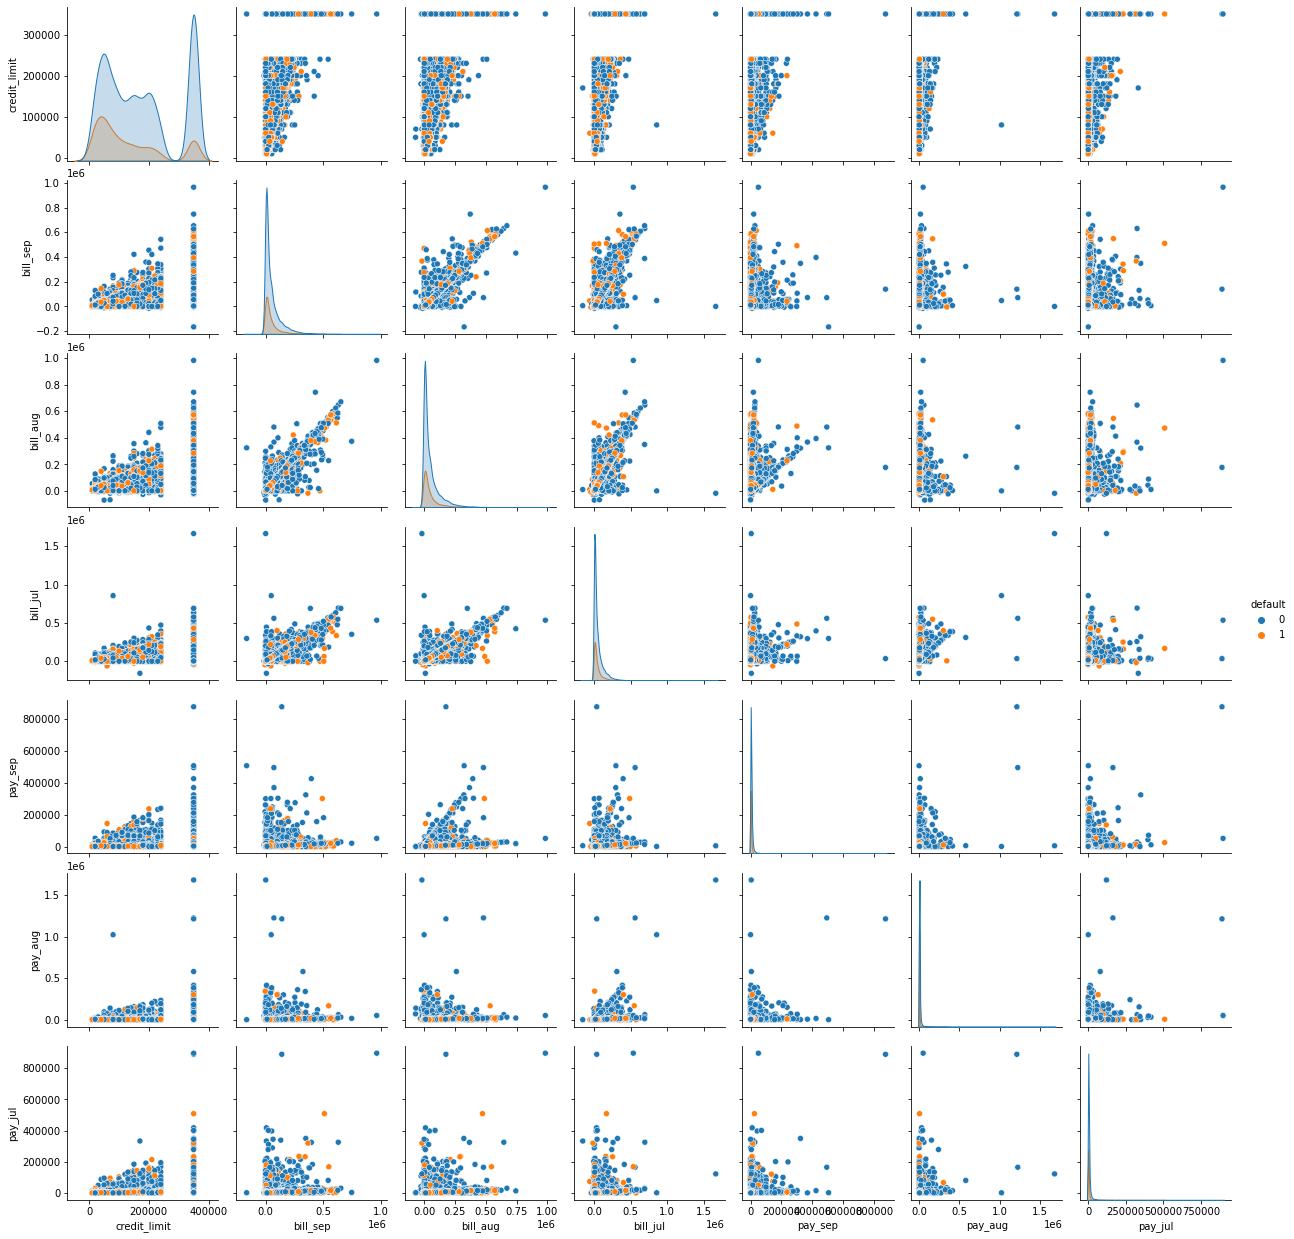

In [598]:
credit = taiwan[check]

sns.pairplot(credit, hue = 'default')
plt.show();

### Marital Status & Credit Limit

''

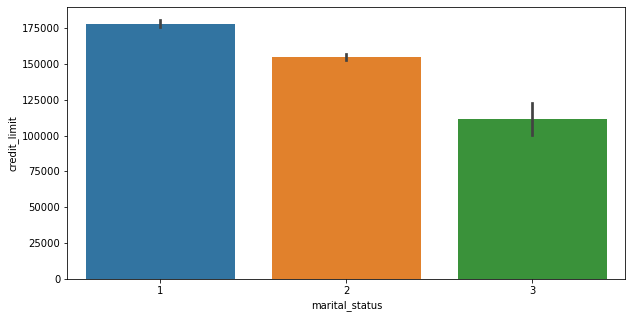

In [599]:
x_line = taiwan['marital_status']
y_line = taiwan['credit_limit']

plt.figure(figsize=(10, 5))
sns.barplot(data = taiwan, x = x_line, y = y_line)
;

### Age & Credit Limit

''

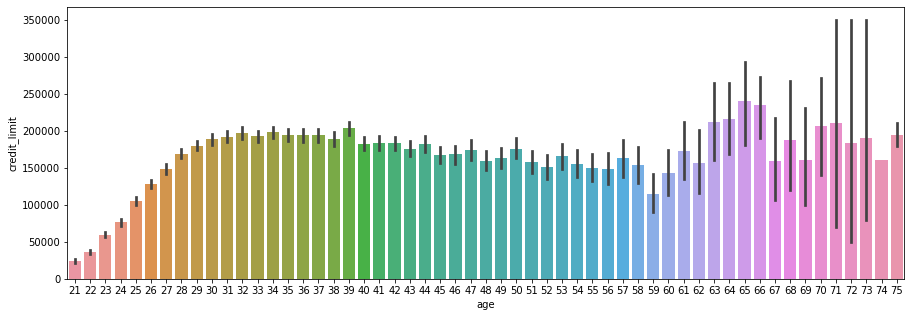

In [600]:
x_line = taiwan['age']
y_line = taiwan['credit_limit']

plt.figure(figsize=(15, 5))
sns.barplot(data = taiwan, x = x_line, y = y_line)
;

### Education Level & Last Month's Bill

''

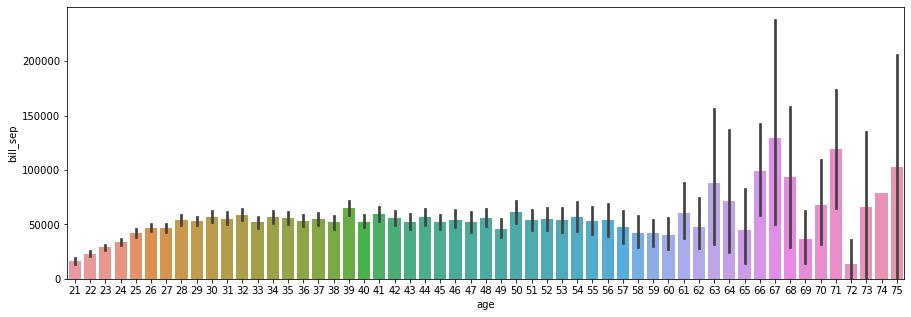

In [601]:
x_line = taiwan['education']
y_line = taiwan['bill_sep']

plt.figure(figsize=(15, 5))
sns.barplot(data = taiwan, x = x_line, y = y_line)
;

### Marital Status vs Credit Limit

<AxesSubplot:xlabel='marital_status', ylabel='credit_limit'>

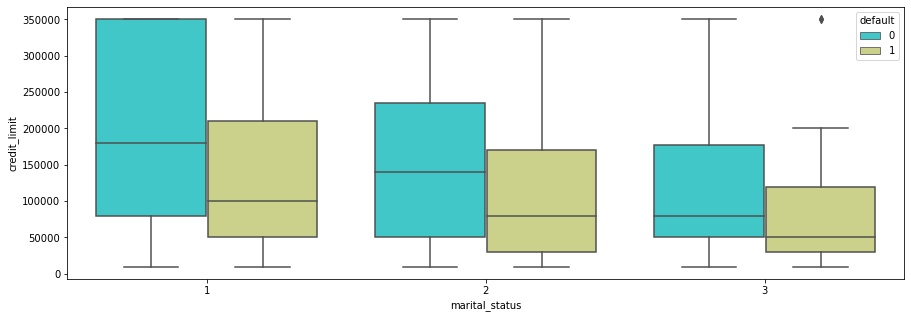

In [602]:
plt.figure(figsize=(15,5))
sns.boxplot(x = 'marital_status', hue = 'default', y = 'credit_limit', data = taiwan, palette = "rainbow")

### Default by Sex

<AxesSubplot:xlabel='gender', ylabel='count'>

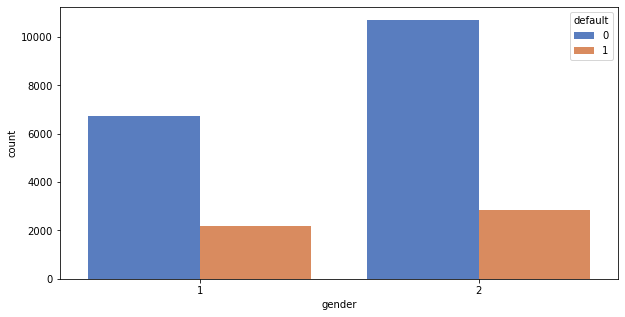

In [603]:
plt.figure(figsize=(10, 5))
sns.countplot(x = 'gender', data = taiwan, hue = 'default', palette = 'muted')

In [604]:
taiwan_corr = taiwan.corr()

In [605]:
taiwan_corr

credit_limit    gender  education  marital_status       age  \
credit_limit        1.000000  0.037435  -0.239810       -0.107745  0.140247   
gender              0.037435  1.000000   0.014108       -0.023167 -0.093937   
education          -0.239810  0.014108   1.000000       -0.138084  0.180827   
marital_status     -0.107745 -0.023167  -0.138084        1.000000 -0.414435   
age                 0.140247 -0.093937   0.180827       -0.414435  1.000000   
repay_sep          -0.174714 -0.027348   0.052549       -0.019674  0.004621   
repay_aug          -0.207187 -0.035181   0.065964       -0.011385 -0.005187   
repay_jul          -0.200938 -0.032921   0.054405        0.002719 -0.018513   
repay_jun          -0.189822 -0.033939   0.052681       -0.004471 -0.006150   
repay_may          -0.181150 -0.035745   0.037997       -0.002349 -0.014766   
repay_apr          -0.174947 -0.025943   0.029810       -0.000818 -0.014120   
bill_sep            0.276418 -0.037009   0.012231       -0.029715  0.058995   
bill_aug            0.270777 -0.032141   0.007064       -0.025966  0.056343   
bill_jul            0.269868 -0.025418   0.003234       -0.029822  0.055082   
bill_jun            0.279459 -0.020942  -0.009284       -0.026614  0.052860   
bill_may            0.280010 -0.016267  -0.015593       -0.027756  0.051109   
bill_apr            0.274847 -0.016368  -0.016725       -0.023524  0.048705   
pay_sep             0.182530  0.004579  -0.041572        0.003434  0.026827   
pay_aug             0.147398 -0.000655  -0.032531       -0.007012  0.019959   
pay_jul             0.180274 -0.006248  -0.044643       -0.000405  0.030200   
pay_jun             0.178265  0.000075  -0.047210       -0.007626  0.018125   
pay_may             0.188894  0.000469  -0.046910       -0.004171  0.023779   
pay_apr             0.199639 -0.001997  -0.046576       -0.005272  0.019674   
default            -0.161677 -0.037953   0.037384       -0.032121  0.014586   

                repay_sep  repay_aug  repay_jul  repay_jun  repay_may  ...  \
credit_limit    -0.174714  -0.207187  -0.200938  -0.189822  -0.181150  ...   
gender          -0.027348  -0.035181  -0.032921  -0.033939  -0.035745  ...   
education        0.052549   0.065964   0.054405   0.052681   0.037997  ...   
marital_status  -0.019674  -0.011385   0.002719  -0.004471  -0.002349  ...   
age              0.004621  -0.005187  -0.018513  -0.006150  -0.014766  ...   
repay_sep        1.000000   0.700821   0.502169   0.447156   0.418157  ...   
repay_aug        0.700821   1.000000   0.658298   0.515417   0.468695  ...   
repay_jul        0.502169   0.658298   1.000000   0.672927   0.537160  ...   
repay_jun        0.447156   0.515417   0.672927   1.000000   0.722543  ...   
repay_may        0.418157   0.468695   0.537160   0.722543   1.000000  ...   
repay_apr        0.375124   0.414353   0.482105   0.577956   0.717934  ...   
bill_sep        -0.019400   0.008905  -0.024550  -0.022959  -0.013532  ...   
bill_aug        -0.009858   0.012642  -0.004998  -0.009401  -0.002632  ...   
bill_jul        -0.004451   0.020071  -0.000544   0.006393   0.009843  ...   
bill_jun         0.004175   0.029514   0.013725   0.019362   0.031219  ...   
bill_may         0.013597   0.038118   0.023274   0.033153   0.045044  ...   
bill_apr         0.013580   0.040353   0.025803   0.038702   0.051119  ...   
pay_sep         -0.086429  -0.097918  -0.043637  -0.055227  -0.053363  ...   
pay_aug         -0.059035  -0.053280  -0.071467  -0.036581  -0.039012  ...   
pay_jul         -0.065887  -0.059547  -0.058808  -0.074303  -0.037855  ...   
pay_jun         -0.063955  -0.052861  -0.053999  -0.054447  -0.065883  ...   
pay_may         -0.062613  -0.047950  -0.053274  -0.052665  -0.052304  ...   
pay_apr         -0.056986  -0.047989  -0.050541  -0.048823  -0.047316  ...   
default          0.394783   0.331835   0.295951   0.275654   0.269613  ...   

                bill_jun  bill_may  bill_apr   pay_sep   pay_aug   pay_jul  \
credit_limi

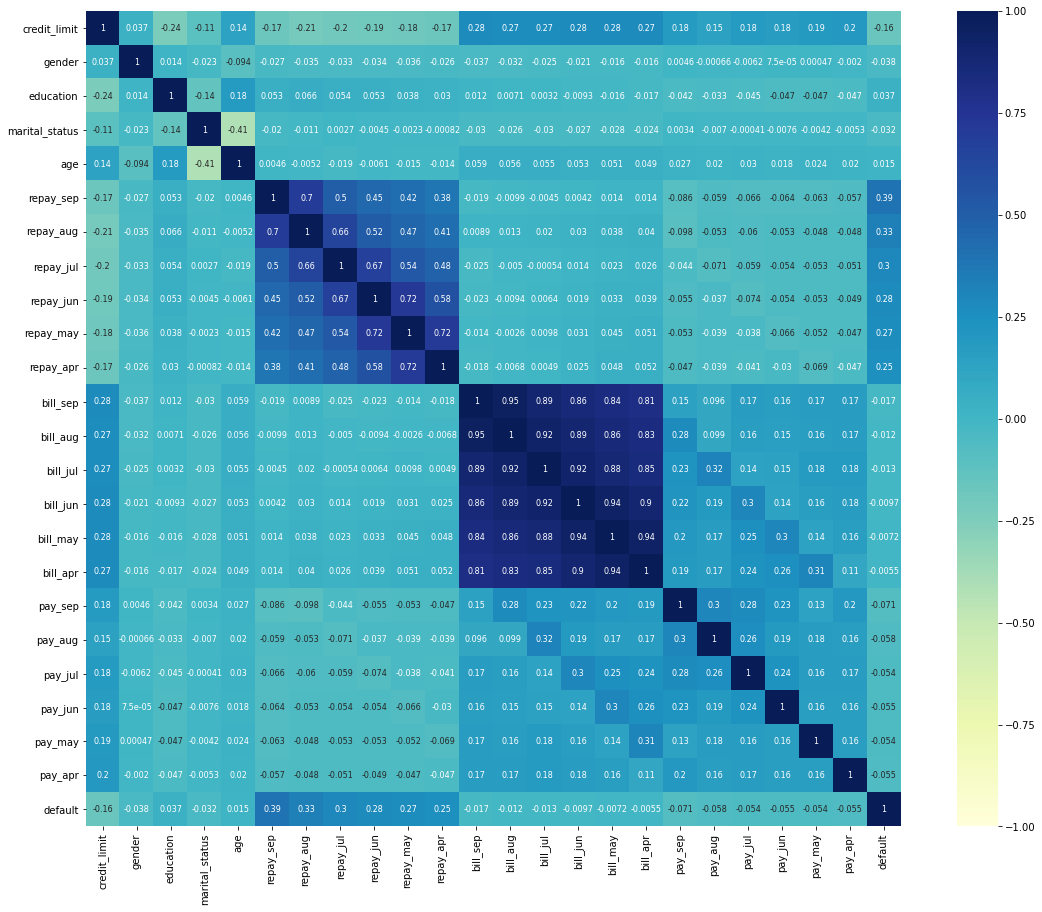

In [606]:
plt.subplots(figsize=(20,15))

corr = taiwan_corr
c1 = corr.abs().unstack()
c1.sort_values(ascending = False)

sns.heatmap(corr, 
    annot=True, 
    annot_kws={"fontsize":8},
    xticklabels = taiwan_corr.columns.values, # x labels
    yticklabels = taiwan_corr.columns.values, # y labels
    vmin = -1, # color scale the min value
    vmax = 1, # color scale the max
    center = 0, # color scale place at the center at 0
    cmap = "YlGnBu", # color palette
    square = True) # each cell will be square-shaped
plt.show();

<AxesSubplot:title={'center':'Correlation with Default'}>

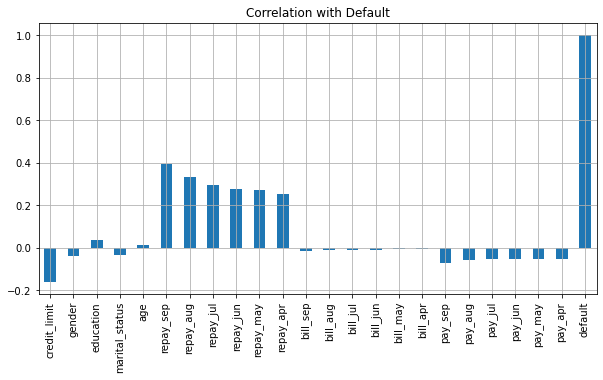

In [607]:
taiwan.corrwith(taiwan.default).plot.bar(figsize = (10, 5), title = "Correlation with Default", 
                                        fontsize = 10,rot = 90, grid = True)

**Takeaways:**
- Credit limit has the highest negative correlation with our target.
- Repayment status for last month (sep) has highest positive correlation.

## 3. Feature Engineering

In [608]:
taiwan.head()

credit_limit  gender  education  marital_status  age  repay_sep  \
28835        220000       2          1               2   36         -1   
25329        200000       2          3               2   29         -1   
18894        180000       2          1               2   27         -1   
690           80000       1          2               2   32         -1   
6239          10000       1          2               2   27         -1   

       repay_aug  repay_jul  repay_jun  repay_may  ...  bill_jun  bill_may  \
28835         -1         -1         -1         -1  ...    221193    181859   
25329         -1         -1         -1         -1  ...       326       326   
18894         -1         -1         -1         -1  ...         0         0   
690           -1         -1         -1         -1  ...     43882     42256   
6239          -1         -1         -1         -1  ...      5444      2639   

       bill_apr  pay_sep  pay_aug  pay_jul  pay_jun  pay_may  pay_apr  default  
28835    184605    10000     8018    10121     6006    10987   143779        1  
25329       326      326      326      326      326      326      326        0  
18894         0        0        0        0        0        0        0        0  
690       42527     1853     1700     1522     1548     1488     1500        0  
6239       2697     2000     1100      600      300      300     1000        1  

[5 rows x 24 columns]

In [609]:
taiwan['credit_limit'].describe()

count     22499.000000
mean     164755.855816
std      119088.099950
min       10000.000000
25%       50000.000000
50%      140000.000000
75%      240000.000000
max      350000.000000
Name: credit_limit, dtype: float64

In [610]:
# Married individuals with advanced degrees
taiwan['married_degree'] = np.where((taiwan.marital_status == 1) & ((taiwan.education == 1) | (taiwan.education == 2)), 1, 0)

# Single individuals with advanced degrees
taiwan['single_degree'] = np.where((taiwan.marital_status >= 2) & ((taiwan.education == 1) | (taiwan.education == 2)), 1, 0)

# Married individuals with HS education
taiwan['single_hs'] = np.where((taiwan.marital_status == 1) & (taiwan.education == 3), 1, 0)

# Single individuals with HS education
taiwan['married_hs'] = np.where((taiwan.marital_status >= 2) & (taiwan.education == 3), 1, 0)

# Married Men with advanced degrees 
taiwan['married_men_adv'] = np.where((taiwan.marital_status == 1) & (taiwan.education <= 2) & (taiwan.gender == 1), 1, 0)

# Single Men with advanced degrees 
taiwan['single_men_adv'] = np.where((taiwan.marital_status >= 2) & (taiwan.education <= 2) & (taiwan.gender == 1), 1, 0)

# Married Women with advanced degrees
taiwan['married_women_adv'] = np.where((taiwan.marital_status == 1) & (taiwan.education <= 2) & (taiwan.gender == 2), 1, 0)

# Single Women with advanced degrees
taiwan['single_women_adv'] = np.where((taiwan.marital_status >= 2) & (taiwan.education <= 2) & (taiwan.gender == 2), 1, 0)

# Married Men without HS diploma
taiwan['married_men_dropout'] = np.where((taiwan.marital_status == 1) & (taiwan.education == 4) & (taiwan.gender == 1), 1, 0)

# Single Men without HS diploma
taiwan['single_men_dropout'] = np.where((taiwan.marital_status >= 2) & (taiwan.education == 4) & (taiwan.gender == 1), 1, 0)

# Married Women without HS diploma
taiwan['married_women_dropout'] = np.where((taiwan.marital_status == 1) & (taiwan.education == 4) & (taiwan.gender == 2), 1, 0)

# Single Women without HS diploma
taiwan['single_women_dropout'] = np.where((taiwan.marital_status >= 2) & (taiwan.education == 4) & (taiwan.gender == 2), 1, 0)

# All individuals with delinquent status over 3 months where last bill was over the mean of 50,000NT
taiwan['delinquent'] = np.where((taiwan.repay_sep == 3) & (taiwan.bill_sep >= 50_000), 1, 0)

# All individuals perfect payments
taiwan['no_risk'] = np.where((taiwan.repay_sep == -1) & (taiwan.repay_aug == -1) & (taiwan.repay_jul == -1) & (taiwan.repay_jun == -1) & (taiwan.repay_may == -1) & (taiwan.repay_apr == -1), 1, 0)



## 4. Feature Selection

### Split the Data for Analysis

In [611]:
# Split data to be used in the models
# Create matrix of features
X = taiwan.drop('default', axis = 1) # grabs everything else but 'default'


# Create target variable
y = taiwan['default'] # y is the column we're trying to predict

In [612]:
X.head()

credit_limit  gender  education  marital_status  age  repay_sep  \
28835        220000       2          1               2   36         -1   
25329        200000       2          3               2   29         -1   
18894        180000       2          1               2   27         -1   
690           80000       1          2               2   32         -1   
6239          10000       1          2               2   27         -1   

       repay_aug  repay_jul  repay_jun  repay_may  ...  married_men_adv  \
28835         -1         -1         -1         -1  ...                0   
25329         -1         -1         -1         -1  ...                0   
18894         -1         -1         -1         -1  ...                0   
690           -1         -1         -1         -1  ...                0   
6239          -1         -1         -1         -1  ...                0   

       single_men_adv  married_women_adv  single_women_adv  \
28835               0                  0                 1   
25329               0                  0                 0   
18894               0                  0                 1   
690                 1                  0                 0   
6239                1                  0                 0   

       married_men_dropout  single_men_dropout  married_women_dropout  \
28835                    0                   0                      0   
25329                    0                   0                      0   
18894                    0                   0                      0   
690                      0                   0                      0   
6239                     0                   0                      0   

       single_women_dropout  delinquent  no_risk  
28835                     0           0        1  
25329                     0           0        1  
18894                     0           0        1  
690                       0           0        1  
6239                      0           0        1  

[5 rows x 37 columns]

In [613]:
print(y.value_counts())
print("y dimensions:", len(y))
print("X dimensions:", len(X))

0    17471
1     5028
Name: default, dtype: int64
y dimensions: 22499
X dimensions: 22499


In [670]:
X.shape

(22499, 37)

### Model Prep

#### Creating Object Data Types

In [614]:
objects = ['gender', 'education', 'marital_status', 'repay_sep', 'repay_aug', 'repay_jul', 'repay_jun', 'repay_may', \
           'repay_apr', 'married_degree', 'single_degree', 'single_hs', 'married_hs', 'married_men_adv', 'single_men_adv', \
          'married_women_adv', 'single_women_adv', 'married_men_dropout', 'single_men_dropout', 'married_women_dropout', \
          'single_women_dropout', 'delinquent', 'no_risk']

X[objects] = X[objects].astype(str)

In [615]:
X.dtypes

credit_limit              int64
gender                   object
education                object
marital_status           object
age                       int64
repay_sep                object
repay_aug                object
repay_jul                object
repay_jun                object
repay_may                object
repay_apr                object
bill_sep                  int64
bill_aug                  int64
bill_jul                  int64
bill_jun                  int64
bill_may                  int64
bill_apr                  int64
pay_sep                   int64
pay_aug                   int64
pay_jul                   int64
pay_jun                   int64
pay_may                   int64
pay_apr                   int64
married_degree           object
single_degree            object
single_hs                object
married_hs               object
married_men_adv          object
single_men_adv           object
married_women_adv        object
single_women_adv         object
married_

In [656]:
X.shape

(22499, 37)

#### Isolating Object Data Types for OHE

In [616]:
X_obj = X.select_dtypes('object')

ohe = OneHotEncoder(
    drop='first',
    sparse=False)

dums = ohe.fit_transform(X_obj)
dums_df = pd.DataFrame(dums,
                       columns=ohe.get_feature_names(),
                       index=X_obj.index)

In [657]:
dums_df.shape

(22499, 66)

In [667]:
dums_df.columns

Index(['x0_2', 'x1_2', 'x1_3', 'x1_4', 'x2_2', 'x2_3', 'x3_1', 'x3_2', 'x3_3',
       'x3_4', 'x3_5', 'x3_6', 'x3_7', 'x3_8', 'x4_1', 'x4_2', 'x4_3', 'x4_4',
       'x4_5', 'x4_6', 'x4_7', 'x4_8', 'x5_1', 'x5_2', 'x5_3', 'x5_4', 'x5_5',
       'x5_6', 'x5_7', 'x5_8', 'x6_1', 'x6_2', 'x6_3', 'x6_4', 'x6_5', 'x6_6',
       'x6_7', 'x6_8', 'x7_2', 'x7_3', 'x7_4', 'x7_5', 'x7_6', 'x7_7', 'x7_8',
       'x8_2', 'x8_3', 'x8_4', 'x8_5', 'x8_6', 'x8_7', 'x8_8', 'x9_1', 'x10_1',
       'x11_1', 'x12_1', 'x13_1', 'x14_1', 'x15_1', 'x16_1', 'x17_1', 'x18_1',
       'x19_1', 'x20_1', 'x21_1', 'x22_1'],
      dtype='object')

#### Isolating Numeric Data Types for Scaling

In [617]:
X_nums = X.select_dtypes('int64')

ss = StandardScaler()

ss.fit(X_nums)
nums_df = pd.DataFrame(ss.transform(X_nums),
                      index=X_nums.index)
nums_df.head()

0         1         2         3         4         5         6   \
28835  0.463903  0.059764  2.298178  2.401353  2.443746  2.753069  2.323672   
25329  0.295957 -0.698022 -0.686596 -0.681832 -0.668172 -0.665625 -0.656302   
18894  0.128010 -0.914533 -0.690974 -0.686363 -0.672834 -0.670671 -0.661654   
690   -0.711723 -0.373257 -0.001126  0.034560  0.007879  0.008557  0.032004   
6239  -1.299536 -0.914533 -0.580095 -0.575247 -0.603065 -0.586406 -0.618333   

             7         8         9         10        11        12        13  
28835  2.436767  0.262938  0.084016  0.267837  0.076423  0.394744  7.742693  
25329 -0.646274 -0.318859 -0.230674 -0.271739 -0.281428 -0.292747 -0.275056  
18894 -0.651729 -0.338464 -0.244011 -0.289697 -0.301967 -0.313769 -0.293276  
690    0.059761 -0.227024 -0.174462 -0.205855 -0.204440 -0.217813 -0.209440  
6239  -0.606607 -0.218184 -0.199008 -0.256645 -0.283066 -0.294423 -0.237385

In [658]:
nums_df.shape

(22499, 14)

In [669]:
nums_df

0         1         2         3         4         5         6   \
28835  0.463903  0.059764  2.298178  2.401353  2.443746  2.753069  2.323672   
25329  0.295957 -0.698022 -0.686596 -0.681832 -0.668172 -0.665625 -0.656302   
18894  0.128010 -0.914533 -0.690974 -0.686363 -0.672834 -0.670671 -0.661654   
690   -0.711723 -0.373257 -0.001126  0.034560  0.007879  0.008557  0.032004   
6239  -1.299536 -0.914533 -0.580095 -0.575247 -0.603065 -0.586406 -0.618333   
...         ...       ...       ...       ...       ...       ...       ...   
16247 -1.047616  0.276275 -0.218520 -0.141598 -0.108203 -0.052707 -0.021379   
2693   1.555556  0.709296 -0.639946 -0.642750 -0.613478 -0.612627 -0.639296   
8076  -0.543776  1.142317 -0.690974 -0.683541 -0.669931 -0.670671 -0.532693   
20213 -1.215563  1.575338 -0.621938 -0.638345 -0.574059 -0.670671 -0.661654   
7624  -1.215563 -1.131043 -0.533471 -0.516305 -0.415470 -0.401159 -0.359245   

             7         8         9         10        11        12        13  
28835  2.436767  0.262938  0.084016  0.267837  0.076423  0.394744  7.742693  
25329 -0.646274 -0.318859 -0.230674 -0.271739 -0.281428 -0.292747 -0.275056  
18894 -0.651729 -0.338464 -0.244011 -0.289697 -0.301967 -0.313769 -0.293276  
690    0.059761 -0.227024 -0.174462 -0.205855 -0.204440 -0.217813 -0.209440  
6239  -0.606607 -0.218184 -0.199008 -0.256645 -0.283066 -0.294423 -0.237385  
...         ...       ...       ...       ...       ...       ...       ...  
16247  0.041943 -0.061819 -0.194917 -0.212575 -0.301967 -0.115860 -0.293276  
2693  -0.514373 -0.149744 -0.073820 -0.083121 -0.158826  0.215665  0.250600  
8076  -0.374943 -0.326256 -0.244011 -0.289697  0.192977  0.331096 -0.244930  
20213 -0.651729 -0.112698  0.038522 -0.273722 -0.301967 -0.313769 -0.293276  
7624  -0.337734 -0.278324  0.001457 -0.289697 -0.201164 -0.262180 -0.248563  

[22499 rows x 14 columns]

#### Concatinating Transformed Datasets

In [618]:
X_clean = pd.concat([nums_df, dums_df], axis=1)
X_clean.head()

0         1         2         3         4         5         6  \
28835  0.463903  0.059764  2.298178  2.401353  2.443746  2.753069  2.323672   
25329  0.295957 -0.698022 -0.686596 -0.681832 -0.668172 -0.665625 -0.656302   
18894  0.128010 -0.914533 -0.690974 -0.686363 -0.672834 -0.670671 -0.661654   
690   -0.711723 -0.373257 -0.001126  0.034560  0.007879  0.008557  0.032004   
6239  -1.299536 -0.914533 -0.580095 -0.575247 -0.603065 -0.586406 -0.618333   

              7         8         9  ...  x13_1  x14_1  x15_1  x16_1  x17_1  \
28835  2.436767  0.262938  0.084016  ...    0.0    0.0    0.0    1.0    0.0   
25329 -0.646274 -0.318859 -0.230674  ...    0.0    0.0    0.0    0.0    0.0   
18894 -0.651729 -0.338464 -0.244011  ...    0.0    0.0    0.0    1.0    0.0   
690    0.059761 -0.227024 -0.174462  ...    0.0    1.0    0.0    0.0    0.0   
6239  -0.606607 -0.218184 -0.199008  ...    0.0    1.0    0.0    0.0    0.0   

       x18_1  x19_1  x20_1  x21_1  x22_1  
28835    0.0    0.0    0.0    0.0    1.0  
25329    0.0    0.0    0.0    0.0    1.0  
18894    0.0    0.0    0.0    0.0    1.0  
690      0.0    0.0    0.0    0.0    1.0  
6239     0.0    0.0    0.0    0.0    1.0  

[5 rows x 80 columns]

#### Train-Test Split our Data 75/25

In [619]:
X_train, X_test, y_train, y_test = train_test_split(X_clean, y, test_size = .25, random_state = 42)

In [568]:
# X_train_obj = X_train.select_dtypes('object')

# ohe = OneHotEncoder(
#     drop='first',
#     sparse=False)

# dums = ohe.fit_transform(X_train_obj)
# dums_df = pd.DataFrame(dums,
#                        columns=ohe.get_feature_names(),
#                        index=X_train_obj.index)
# dums_df.head()

x0_2  x1_2  x1_3  x1_4  x2_2  x2_3  x3_1  x3_2  x3_3  x3_4  ...  x13_1  \
27817   1.0   1.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   
10498   1.0   0.0   1.0   0.0   1.0   0.0   0.0   1.0   0.0   0.0  ...    0.0   
508     1.0   1.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   
25974   1.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   
4010    0.0   1.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   

       x14_1  x15_1  x16_1  x17_1  x18_1  x19_1  x20_1  x21_1  x22_1  
27817    0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0    1.0  
10498    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
508      0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0    0.0  
25974    0.0    1.0    0.0    0.0    0.0    0.0    0.0    0.0    1.0  
4010     1.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    1.0  

[5 rows x 66 columns]

In [569]:
# X_test_obj = X_test.select_dtypes('object')

# ohe = OneHotEncoder(
#     drop='first',
#     sparse=False)

# dums_test = ohe.fit_transform(X_test_obj)
# dums_test_df = pd.DataFrame(dums_test,
#                        columns=ohe.get_feature_names(),
#                        index=X_test_obj.index)
# dums_test_df.head()

x0_2  x1_2  x1_3  x1_4  x2_2  x2_3  x3_1  x3_2  x3_3  x3_4  ...  x13_1  \
13145   1.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   
26785   0.0   1.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   1.0  ...    0.0   
14801   0.0   0.0   1.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   
22155   1.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   
2339    1.0   1.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   

       x14_1  x15_1  x16_1  x17_1  x18_1  x19_1  x20_1  x21_1  x22_1  
13145    0.0    1.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
26785    1.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
14801    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    1.0  
22155    0.0    1.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
2339     0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0    1.0  

[5 rows x 59 columns]

In [541]:
# X_test_nums = X_test.select_dtypes('int64')

# ss = StandardScaler()

# ss.fit(X_train_nums)
# nums_test_df = pd.DataFrame(ss.transform(X_test_nums),
#                       index=X_test_nums.index)
# nums_test_df.head()

0         1         2         3         4         5         6   \
13145 -0.711432  1.461431 -0.658335 -0.678383 -0.661929 -0.660488 -0.646099   
26785 -0.037541 -1.023386  1.360160  1.426196  1.535928  1.753950  1.845763   
14801 -0.458723  0.056969 -0.654491 -0.666318 -0.667466 -0.666493 -0.657873   
22155  0.299404 -0.591244 -0.662956 -0.660354 -0.577826 -0.573587 -0.559335   
2339  -0.121778 -0.915351 -0.622279 -0.597294 -0.620900 -0.494554 -0.397974   

             7         8         9         10        11        12        13  
13145 -0.644097 -0.336430 -0.212457 -0.258467 -0.250581 -0.309514 -0.263968  
26785  2.070411 -0.144923  0.032923  0.038649 -0.294349  0.444743 -0.288876  
14801 -0.649621 -0.261024 -0.226935 -0.279122 -0.294349 -0.309514 -0.288876  
22155 -0.608013 -0.336430  0.007457 -0.279122 -0.294349 -0.309514 -0.288876  
2339  -0.378107  0.036829 -0.105173  0.312304  0.312701 -0.266395 -0.269858

## 5. Model Fitting and Hyperparameter Tuning
KNN, Logistic Regression, Decision Tree

#### Logistic Regression

In [635]:
lm = LogisticRegression(random_state = 10, max_iter = 1000)
lm.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=10)

In [636]:
y_pred = lm.predict(X_test)

In [637]:
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

results = pd.DataFrame([['Logistic Regression', acc, prec, rec, f1]],
               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])
results

Model  Accuracy  Precision    Recall  F1 Score
0  Logistic Regression  0.819911   0.696375  0.362137  0.476486

#### KNN

In [638]:
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=7)

In [639]:
y_pred = knn.predict(X_test)

In [640]:
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

model = pd.DataFrame([['KNN', acc, prec, rec, f1]],
               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])
results = results.append(model, ignore_index = True)
results

Model  Accuracy  Precision    Recall  F1 Score
0  Logistic Regression  0.819911   0.696375  0.362137  0.476486
1                  KNN  0.795556   0.593607  0.306363  0.404145

#### Decision Tree

In [641]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [642]:
y_pred = dt.predict(X_test)

In [643]:
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

model = pd.DataFrame([['Decision Tree', acc, prec, rec, f1]],
               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])
results = results.append(model, ignore_index = True)
results

Model  Accuracy  Precision    Recall  F1 Score
0  Logistic Regression  0.819911   0.696375  0.362137  0.476486
1                  KNN  0.795556   0.593607  0.306363  0.404145
2        Decision Tree  0.731200   0.406714  0.409269  0.407987

#### XGBoost

In [645]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [646]:
y_pred = xgb.predict(X_test)

In [648]:
cm = confusion_matrix(y_test, y_pred)

In [649]:
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

model = pd.DataFrame([['XGBoost', acc, prec, rec, f1]],
               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])
results = results.append(model, ignore_index = True)
results

Model  Accuracy  Precision    Recall  F1 Score
0  Logistic Regression  0.819911   0.696375  0.362137  0.476486
1                  KNN  0.795556   0.593607  0.306363  0.404145
2        Decision Tree  0.731200   0.406714  0.409269  0.407987
3              XGBoost  0.813156   0.655899  0.366850  0.470529

## 6. Model Evaluation

- The Logistic Regression Model has the best F1 Score in determining whether or not a client will default on their next credit payment.
    - We'll select that model to test on the holdout data.

## 7. Final Model

In [650]:
final_model = LogisticRegression(random_state = 10, max_iter = 1000)

final_model.fit(X_clean, y)

LogisticRegression(max_iter=1000, random_state=10)

In [651]:
final_acc = accuracy_score(y_test, y_pred)
final_prec = precision_score(y_test, y_pred)
final_rec = recall_score(y_test, y_pred)
final_f1 = f1_score(y_test, y_pred)

final_results = pd.DataFrame([['Logistic Regression', acc, prec, rec, f1]],
               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])
final_results

Model  Accuracy  Precision   Recall  F1 Score
0  Logistic Regression  0.813156   0.655899  0.36685  0.470529

In [652]:
import pickle

pickle_out = open("model.pickle","wb")
pickle.dump(final_model, pickle_out)
pickle_out.close()

In [662]:
other_info = [objects, ss]

In [663]:
pickle_out = open('other_info.pickle', "wb")
pickle.dump(other_info, pickle_out)
pickle_out.close()